In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow.keras as keras
import re

2023-03-23 14:03:47.679944: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization, SpatialDropout1D, Embedding, LSTM
from nltk.tokenize import sent_tokenize,word_tokenize
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
df = pd.read_csv('./twitter_training.csv')

In [4]:
df.columns = ['Tweet Id','Entity','sentiment','Tweet content']

In [5]:
df.head()

,Tweet Id,Entity,sentiment,Tweet content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [6]:
df.isnull().sum()

Tweet Id           0
Entity             0
sentiment          0
Tweet content    686
dtype: int64

In [7]:
df = df.dropna()

In [8]:
df.shape

(73995, 4)

In [9]:
df["sentiment"].value_counts()

Negative      22358
Positive      20654
Neutral       18108
Irrelevant    12875
Name: sentiment, dtype: int64

In [10]:
df = df[df["sentiment"]!="Irrelevant"]
df.shape

(61120, 4)

In [11]:
df_2=df
df.drop(columns=['Tweet Id','Entity'],inplace=True)

In [12]:
df_2.head()

,sentiment,Tweet content
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...


In [13]:
df_2.iloc[1000-1,1]

'Eli Whitney Roth International is making a movie based loosely on using the game,.. bit. ly / on 2wv4KHM'

## Text Preprocessing

In [14]:
from nltk.corpus import stopwords

In [15]:
sw = stopwords.words('english')

In [16]:
sw.remove('not')
sw.remove('no')

In [17]:
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

In [18]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/senaabhishek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/senaabhishek/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [20]:
lemmatizer = WordNetLemmatizer()

In [21]:
def clean_data(text):
    new_review = BeautifulSoup(text).get_text()
    
    no_urls = new_review.replace('http\S+','').replace('www\S+','')
    
    no_numbers = re.sub("[^a-zA-Z]"," ",no_urls)
    
    new_words = no_numbers.lower().split()
    
    stops = set(sw)
    
    final_words = [lemmatizer.lemmatize(word) for word in new_words if word not in stops]
    
    return (" ".join(final_words))

### Running the loop through review

In [22]:
df_2["cleaned_reviw"] = df_2['Tweet content'].apply(lambda x:clean_data(x))

/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [23]:
df_2.iloc[1000-1,2]


'eli whitney roth international making movie based loosely using game bit ly wv khm'

In [24]:
df_2.iloc[1000-1,1]

'Eli Whitney Roth International is making a movie based loosely on using the game,.. bit. ly / on 2wv4KHM'

## to find the max_length of reviews to assign vocab length

<AxesSubplot:xlabel='n_words', ylabel='Count'>

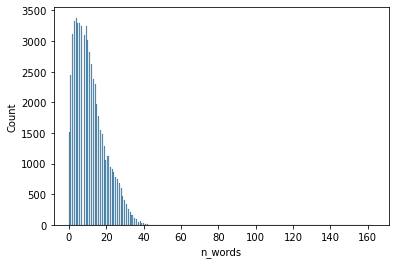

In [25]:
df_2['n_words'] = df_2['cleaned_reviw'].apply(lambda x:len(x.split()))
sns.histplot(data=df_2,x="n_words")

we can see that only few words are above lenght 40

In [26]:
max_length = 40

In [27]:
df_2.head()

,sentiment,Tweet content,cleaned_reviw,n_words
0,Positive,I am coming to the borders and I will kill you...,coming border kill,3
1,Positive,im getting on borderlands and i will kill you ...,im getting borderland kill,4
2,Positive,im coming on borderlands and i will murder you...,im coming borderland murder,4
3,Positive,im getting on borderlands 2 and i will murder ...,im getting borderland murder,4
4,Positive,im getting into borderlands and i can murder y...,im getting borderland murder,4


In [28]:
df_3 = df_2

sentiment = pd.get_dummies(df_2["sentiment"])
df_3 = pd.concat([df_3,sentiment],axis=1)

df_3.drop(columns=["sentiment","Tweet content","n_words"],inplace=True)

In [29]:
df_3

,cleaned_reviw,Negative,Neutral,Positive
0,coming border kill,0,0,1
1,im getting borderland kill,0,0,1
2,im coming borderland murder,0,0,1
3,im getting borderland murder,0,0,1
4,im getting borderland murder,0,0,1
...,...,...,...,...
74676,realized window partition mac like year behind...,0,0,1
74677,realized mac window partition year behind nvid...,0,0,1
74678,realized window partition mac year behind nvid...,0,0,1
74679,realized window partition mac like year behind...,0,0,1


## Tokenizing

In [30]:
top_words=10000
tokenizer = Tokenizer(num_words=10000, split=' ')
tokenizer.fit_on_texts(df_3["cleaned_reviw"].values)
sequences = tokenizer.texts_to_sequences(df_3["cleaned_reviw"].values)
word_index = tokenizer.word_index



X = pad_sequences(sequences,maxlen=max_length,padding='post')

In [31]:
len(word_index)

23092

In [32]:
X[999]

array([2107, 4716, 1599,  227,  495,  371,  298,    1,  179,  192, 4724,
       7703,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [33]:
y=df_3[['Negative','Neutral','Positive']]

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
vectorized_words = cv.fit_transform(df_3["cleaned_reviw"])


In [35]:
len(cv.vocabulary_)

23068

In [36]:
y.head(20)

,Negative,Neutral,Positive
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
5,0,0,1
6,0,0,1
7,0,0,1
8,0,0,1
9,0,0,1


### splitting training set and test set

In [37]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.01,random_state=45)
X_train.shape,X_test.shape

((60508, 40), (612, 40))

In [38]:
y_train.shape,y_test.shape

((60508, 3), (612, 3))

## creating the model using LSTM

In [39]:
#n_most_words =len(cv.vocabulary_)+1
n_most_words = 23092

In [40]:
#n_dim =50
n_dim =128

In [41]:
model = Sequential()

model.add(Embedding(top_words,n_dim,input_length = X_train.shape[1]))

model.add(SpatialDropout1D(0.25))

model.add(LSTM(100,dropout=0.25,recurrent_dropout=0.25))

model.add(Dense(50,activation='relu'))
model.add(Dense(25,activation='relu'))
model.add(Dense(3,activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
#categorical_crossentropy
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 128)           1280000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 40, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               91600     
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dense_1 (Dense)             (None, 25)                1275      
                                                                 
 dense_2 (Dense)             (None, 3)                 78        
                                                        

2023-03-23 14:03:58.941957: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [42]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(patience=5)
model_history = model.fit(X_train,y_train,epochs=20,validation_split = 0.1,batch_size = 128 ,validation_data=(X_test,y_test),callbacks=[early_stop,checkpoint])
#model_history = model.fit(x=X_train,y=y_train,epochs=30,validation_split=0.1,batch_size=128,callbacks=[checkpoint,early_stop])

Epoch 1/20
473/473 [==============================] - 26s 52ms/step - loss: 0.5744 - acc: 0.4953 - val_loss: 0.4531 - val_acc: 0.6863
Epoch 2/20
473/473 [==============================] - 24s 52ms/step - loss: 0.3525 - acc: 0.7711 - val_loss: 0.3143 - val_acc: 0.7974
Epoch 3/20
473/473 [==============================] - 24s 51ms/step - loss: 0.2604 - acc: 0.8376 - val_loss: 0.2509 - val_acc: 0.8399
Epoch 4/20
473/473 [==============================] - 25s 53ms/step - loss: 0.2209 - acc: 0.8580 - val_loss: 0.2285 - val_acc: 0.8611
Epoch 5/20
473/473 [==============================] - 25s 53ms/step - loss: 0.1982 - acc: 0.8705 - val_loss: 0.2259 - val_acc: 0.8529
Epoch 6/20
473/473 [==============================] - 33s 70ms/step - loss: 0.1783 - acc: 0.8823 - val_loss: 0.2228 - val_acc: 0.8578
Epoch 7/20
473/473 [==============================] - 24s 52ms/step - loss: 0.1638 - acc: 0.8917 - val_loss: 0.1986 - val_acc: 0.8676
Epoch 8/20
473/473 [==============================] - 25s 53ms

In [43]:
model.evaluate(X_train, y_train)

1891/1891 [==============================] - 12s 6ms/step - loss: 0.0956 - acc: 0.9316


[0.09561561793088913, 0.9315627813339233]

In [44]:
model.evaluate(X_test, y_test)

20/20 [==============================] - 0s 6ms/step - loss: 0.2126 - acc: 0.8791


[0.21261437237262726, 0.8790849447250366]

## Using our model for predicting 

In [45]:
def predict_sentiment(review):
    seq = tokenizer.texts_to_sequences(review)
    padded = pad_sequences(seq,maxlen=max_length)
    pred = model.predict(padded)
    label = ['Negative','Neutral','Positive']
    return label[np.argmax(pred)]


In [46]:
df.iloc[1]

sentiment                                                 Positive
Tweet content    im getting on borderlands and i will kill you ...
cleaned_reviw                           im getting borderland kill
n_words                                                          4
Name: 1, dtype: object

In [47]:
predict_sentiment(["im getting on borderlands and i will kill you ..."])

1/1 [==============================] - 0s 191ms/step


'Negative'

In [48]:
df_test= pd.read_csv("./twitter_validation.csv",header=None)

In [49]:
df_test.head()

,0,1,2,3
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [50]:
df_test = df_test[df_test[2]!='Irrelevant']

In [51]:
df_test["predicted"] = df_test[3].apply(lambda x:predict_sentiment([x]))

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step


In [52]:
df_test.head(20)

,0,1,2,3,predicted
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,Negative
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,Negative
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",Negative
4,4433,Google,Neutral,Now the President is slapping Americans in the...,Neutral
5,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,Negative
6,7925,MaddenNFL,Positive,Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...,Negative
7,11332,TomClancysRainbowSix,Positive,"Rocket League, Sea of Thieves or Rainbow Six: ...",Neutral
8,1107,AssassinsCreed,Positive,my ass still knee-deep in Assassins Creed Odys...,Positive
9,2069,CallOfDuty,Negative,FIX IT JESUS ! Please FIX IT ! What In the wor...,Negative
10,3185,Dota2,Positive,The professional dota 2 scene is fucking explo...,Positive


Neutral     285
Positive    277
Negative    266
Name: 2, dtype: int64